In [97]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [98]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [99]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [100]:
hue_order = [
    #'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    'RNN-Oja',
    'Linear'
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [101]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0448421052631579/sigma1.5/0.6/
results.p
model.pt
events.out.tfevents.1641489351.mushroombody.aronov.zi.columbia.edu.43105.64
events.out.tfevents.1641486271.mushroombody.aronov.zi.columbia.edu.43105.62
events.out.tfevents.1641487805.mushroombody.aronov.zi.columbia.edu.43105.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0448421052631579/sigma1.5/0.75/
results.p
model.pt
events.out.tfevents.1641461758.mushroombody.aronov.zi.columbia.edu.43105.39
results.p
model.pt
events.out.tfevents.1641461566.mushroombody.aronov.zi.columbia.edu.43105.37
results.p
model.pt
events.out.tfevents.1641461648.mushroombody.aronov.zi.columbia.edu.43105.38
results.p
model.pt
events.out.tfevents.1641458797.mushroombody.aronov.zi.columbia.edu.43105.29
results.p
model.pt
events.out.tfevents.1641453414.mushroombody.aronov.zi.columbia.edu.43105.27
results.p
events.out.tfevents.1641456105.mushroombody.aronov.zi.columbia.edu.43105.28
events.out.tfeven

results.p
events.out.tfevents.1641439642.mushroombody.aronov.zi.columbia.edu.43088.16
results.p
model.pt
events.out.tfevents.1641439622.mushroombody.aronov.zi.columbia.edu.43088.14
events.out.tfevents.1641439632.mushroombody.aronov.zi.columbia.edu.43088.15
results.p
model.pt
events.out.tfevents.1641425205.mushroombody.aronov.zi.columbia.edu.43088.4
events.out.tfevents.1641419776.mushroombody.aronov.zi.columbia.edu.43088.2
results.p
model.pt
events.out.tfevents.1641422487.mushroombody.aronov.zi.columbia.edu.43088.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma3.0/0.8/
results.p
events.out.tfevents.1641363110.mushroombody.aronov.zi.columbia.edu.34074.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641363007.mushroombody.aronov.zi.columbia.edu.34074.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641363060.mushroombody.aronov.zi.columbia.edu.34074.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641361317.mushroombody.aronov.zi.

results.p
model.pt
events.out.tfevents.1641485142.mushroombody.aronov.zi.columbia.edu.43080.58
results.p
events.out.tfevents.1641482215.mushroombody.aronov.zi.columbia.edu.43080.49
results.p
model.pt
events.out.tfevents.1641476757.mushroombody.aronov.zi.columbia.edu.43080.47
events.out.tfevents.1641479461.mushroombody.aronov.zi.columbia.edu.43080.48
results.p
events.out.tfevents.1641485036.mushroombody.aronov.zi.columbia.edu.43080.56
results.p
model.pt
events.out.tfevents.1641485018.mushroombody.aronov.zi.columbia.edu.43080.54
results.p
events.out.tfevents.1641485027.mushroombody.aronov.zi.columbia.edu.43080.55
results.p
model.pt
events.out.tfevents.1641471051.mushroombody.aronov.zi.columbia.edu.43080.44
events.out.tfevents.1641465556.mushroombody.aronov.zi.columbia.edu.43080.42
results.p
events.out.tfevents.1641468271.mushroombody.aronov.zi.columbia.edu.43080.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03/sigma2.5/0.75/
events.out.tfevents.1641484764.mushroombody.aronov

results.p
events.out.tfevents.1641439189.mushroombody.aronov.zi.columbia.edu.43138.17
results.p
model.pt
events.out.tfevents.1641439285.mushroombody.aronov.zi.columbia.edu.43138.18
results.p
events.out.tfevents.1641436416.mushroombody.aronov.zi.columbia.edu.43138.9
events.out.tfevents.1641430987.mushroombody.aronov.zi.columbia.edu.43138.7
results.p
model.pt
events.out.tfevents.1641433722.mushroombody.aronov.zi.columbia.edu.43138.8
results.p
model.pt
events.out.tfevents.1641439180.mushroombody.aronov.zi.columbia.edu.43138.16
results.p
model.pt
events.out.tfevents.1641439162.mushroombody.aronov.zi.columbia.edu.43138.14
results.p
events.out.tfevents.1641439171.mushroombody.aronov.zi.columbia.edu.43138.15
events.out.tfevents.1641425042.mushroombody.aronov.zi.columbia.edu.43138.4
results.p
model.pt
events.out.tfevents.1641419696.mushroombody.aronov.zi.columbia.edu.43138.2
results.p
model.pt
events.out.tfevents.1641422361.mushroombody.aronov.zi.columbia.edu.43138.3
/home/chingf/engram/Ching/

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0040526315789473685/sigma2.5/0.6/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0040526315789473685/sigma2.5/0.75/
results.p
model.pt
events.out.tfevents.1641462607.mushroombody.aronov.zi.columbia.edu.43110.39
results.p
model.pt
events.out.tfevents.1641462412.mushroombody.aronov.zi.columbia.edu.43110.37
results.p
model.pt
events.out.tfevents.1641462511.mushroombody.aronov.zi.columbia.edu.43110.38
results.p
events.out.tfevents.1641459544.mushroombody.aronov.zi.columbia.edu.43110.29
results.p
model.pt
events.out.tfevents.1641454127.mushroombody.aronov.zi.columbia.edu.43110.27
results.p
events.out.tfevents.1641456837.mushroombody.aronov.zi.columbia.edu.43110.28
results.p
events.out.tfevents.1641462402.mushroombody.aronov.zi.columbia.edu.43110.36
results.p
model.pt
events.out.tfevents.1641462384.mushroombody.aronov.zi.columbia.edu.43110.34
results.p
events.out.tfevents.1641462393.mushroombody.aronov.zi.columbia.edu.43110.35


results.p
model.pt
field_infos.p
events.out.tfevents.1641352867.mushroombody.aronov.zi.columbia.edu.34117.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01836842105263158/sigma3.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641319021.mushroombody.aronov.zi.columbia.edu.34129.59
events.out.tfevents.1641318832.mushroombody.aronov.zi.columbia.edu.34129.57
events.out.tfevents.1641318930.mushroombody.aronov.zi.columbia.edu.34129.58
results.p
events.out.tfevents.1641317082.mushroombody.aronov.zi.columbia.edu.34129.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641313795.mushroombody.aronov.zi.columbia.edu.34129.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641315450.mushroombody.aronov.zi.columbia.edu.34129.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641318823.mushroombody.aronov.zi.columbia.edu.34129.56
events.out.tfevents.1641318806.mushroombody.aronov.zi.columbia.edu.34129.54
results.p
model.pt
field_infos.p
events.out.tfevents.

events.out.tfevents.1641419694.mushroombody.aronov.zi.columbia.edu.43129.2
results.p
model.pt
events.out.tfevents.1641422352.mushroombody.aronov.zi.columbia.edu.43129.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06189473684210526/sigma1.25/0.6/
events.out.tfevents.1641489225.mushroombody.aronov.zi.columbia.edu.43103.79
results.p
model.pt
events.out.tfevents.1641489063.mushroombody.aronov.zi.columbia.edu.43103.77
events.out.tfevents.1641489145.mushroombody.aronov.zi.columbia.edu.43103.78
results.p
events.out.tfevents.1641487427.mushroombody.aronov.zi.columbia.edu.43103.69
results.p
events.out.tfevents.1641484197.mushroombody.aronov.zi.columbia.edu.43103.67
results.p
model.pt
events.out.tfevents.1641485837.mushroombody.aronov.zi.columbia.edu.43103.68
results.p
model.pt
events.out.tfevents.1641489054.mushroombody.aronov.zi.columbia.edu.43103.76
results.p
model.pt
events.out.tfevents.1641489038.mushroombody.aronov.zi.columbia.edu.43103.74
results.p
model.pt
events.out.tfevents

results.p
events.out.tfevents.1641484400.mushroombody.aronov.zi.columbia.edu.43112.55
results.p
events.out.tfevents.1641470597.mushroombody.aronov.zi.columbia.edu.43112.44
results.p
model.pt
events.out.tfevents.1641465225.mushroombody.aronov.zi.columbia.edu.43112.42
results.p
events.out.tfevents.1641467914.mushroombody.aronov.zi.columbia.edu.43112.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.08957894736842105/sigma1.0/0.8/
results.p
events.out.tfevents.1641347095.mushroombody.aronov.zi.columbia.edu.34120.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641346643.mushroombody.aronov.zi.columbia.edu.34120.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641346876.mushroombody.aronov.zi.columbia.edu.34120.78
results.p
model.pt
events.out.tfevents.1641338342.mushroombody.aronov.zi.columbia.edu.34120.69
results.p
model.pt
events.out.tfevents.1641329685.mushroombody.aronov.zi.columbia.edu.34120.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641334053.m

results.p
model.pt
field_infos.p
events.out.tfevents.1641293436.mushroombody.aronov.zi.columbia.edu.34084.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641290029.mushroombody.aronov.zi.columbia.edu.34084.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641291729.mushroombody.aronov.zi.columbia.edu.34084.28
results.p
model.pt
events.out.tfevents.1641295200.mushroombody.aronov.zi.columbia.edu.34084.36
events.out.tfevents.1641295181.mushroombody.aronov.zi.columbia.edu.34084.34
results.p
events.out.tfevents.1641295191.mushroombody.aronov.zi.columbia.edu.34084.35
events.out.tfevents.1641286564.mushroombody.aronov.zi.columbia.edu.34084.24
results.p
events.out.tfevents.1641283135.mushroombody.aronov.zi.columbia.edu.34084.22
results.p
model.pt
events.out.tfevents.1641284859.mushroombody.aronov.zi.columbia.edu.34084.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1266842105263158/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280808.mushroo

results.p
events.out.tfevents.1641439202.mushroombody.aronov.zi.columbia.edu.43099.17
results.p
model.pt
events.out.tfevents.1641439299.mushroombody.aronov.zi.columbia.edu.43099.18
results.p
model.pt
events.out.tfevents.1641436431.mushroombody.aronov.zi.columbia.edu.43099.9
results.p
model.pt
events.out.tfevents.1641431039.mushroombody.aronov.zi.columbia.edu.43099.7
results.p
model.pt
events.out.tfevents.1641433762.mushroombody.aronov.zi.columbia.edu.43099.8
results.p
events.out.tfevents.1641439193.mushroombody.aronov.zi.columbia.edu.43099.16
results.p
events.out.tfevents.1641439175.mushroombody.aronov.zi.columbia.edu.43099.14
results.p
events.out.tfevents.1641439184.mushroombody.aronov.zi.columbia.edu.43099.15
results.p
events.out.tfevents.1641425060.mushroombody.aronov.zi.columbia.edu.43099.4
events.out.tfevents.1641419697.mushroombody.aronov.zi.columbia.edu.43099.2
results.p
model.pt
events.out.tfevents.1641422370.mushroombody.aronov.zi.columbia.edu.43099.3
/home/chingf/engram/Ching

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03226315789473684/sigma1.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280738.mushroombody.aronov.zi.columbia.edu.34107.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280527.mushroombody.aronov.zi.columbia.edu.34107.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280629.mushroombody.aronov.zi.columbia.edu.34107.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277560.mushroombody.aronov.zi.columbia.edu.34107.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271349.mushroombody.aronov.zi.columbia.edu.34107.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274682.mushroombody.aronov.zi.columbia.edu.34107.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641280518.mushroombody.aronov.zi.columbia.edu.34107.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280499.mushroombody.aronov.zi.columbia.edu.34107.14
events.out.tfevents.1641280508.mushroombod

events.out.tfevents.1641287037.mushroombody.aronov.zi.columbia.edu.34082.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.6/
results.p
model.pt
events.out.tfevents.1641486978.mushroombody.aronov.zi.columbia.edu.43082.62
results.p
model.pt
events.out.tfevents.1641488504.mushroombody.aronov.zi.columbia.edu.43082.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.75/
events.out.tfevents.1641462256.mushroombody.aronov.zi.columbia.edu.43134.39
results.p
model.pt
events.out.tfevents.1641462083.mushroombody.aronov.zi.columbia.edu.43134.37
results.p
model.pt
events.out.tfevents.1641462169.mushroombody.aronov.zi.columbia.edu.43134.38
results.p
events.out.tfevents.1641459266.mushroombody.aronov.zi.columbia.edu.43134.29
results.p
model.pt
events.out.tfevents.1641453816.mushroombody.aronov.zi.columbia.edu.43134.27
results.p
model.pt
events.out.tfevents.1641456549.mushroombody.aronov.zi.columbia.edu.43134.28
results.p
m

results.p
events.out.tfevents.1641439465.mushroombody.aronov.zi.columbia.edu.43093.16
results.p
model.pt
events.out.tfevents.1641439446.mushroombody.aronov.zi.columbia.edu.43093.14
results.p
model.pt
events.out.tfevents.1641439455.mushroombody.aronov.zi.columbia.edu.43093.15
events.out.tfevents.1641425206.mushroombody.aronov.zi.columbia.edu.43093.4
results.p
model.pt
events.out.tfevents.1641419777.mushroombody.aronov.zi.columbia.edu.43093.2
results.p
model.pt
events.out.tfevents.1641422497.mushroombody.aronov.zi.columbia.edu.43093.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016157894736842104/sigma2.25/0.6/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016157894736842104/sigma2.25/0.75/
events.out.tfevents.1641462409.mushroombody.aronov.zi.columbia.edu.43143.39
results.p
events.out.tfevents.1641462208.mushroombody.aronov.zi.columbia.edu.43143.37
events.out.tfevents.1641462304.mushroombody.aronov.zi.columbia.edu.43143.38
events.out.tfevents.1641459384.mushroombod

events.out.tfevents.1641361443.mushroombody.aronov.zi.columbia.edu.34097.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641361447.mushroombody.aronov.zi.columbia.edu.34097.75
events.out.tfevents.1641352366.mushroombody.aronov.zi.columbia.edu.34097.64
results.p
events.out.tfevents.1641344350.mushroombody.aronov.zi.columbia.edu.34097.62
results.p
model.pt
events.out.tfevents.1641349713.mushroombody.aronov.zi.columbia.edu.34097.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002157894736842105/sigma3.0/0.6/
results.p
model.pt
events.out.tfevents.1641310066.mushroombody.aronov.zi.columbia.edu.34120.59
events.out.tfevents.1641309840.mushroombody.aronov.zi.columbia.edu.34120.57
results.p
events.out.tfevents.1641309962.mushroombody.aronov.zi.columbia.edu.34120.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641308005.mushroombody.aronov.zi.columbia.edu.34120.49
results.p
model.pt
events.out.tfevents.1641304550.mushroombody.aronov.zi.columbia.edu.34120.47
results.

events.out.tfevents.1641316995.mushroombody.aronov.zi.columbia.edu.34108.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641313720.mushroombody.aronov.zi.columbia.edu.34108.47
results.p
events.out.tfevents.1641315371.mushroombody.aronov.zi.columbia.edu.34108.48
results.p
model.pt
events.out.tfevents.1641318723.mushroombody.aronov.zi.columbia.edu.34108.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641318706.mushroombody.aronov.zi.columbia.edu.34108.54
events.out.tfevents.1641318715.mushroombody.aronov.zi.columbia.edu.34108.55
results.p
events.out.tfevents.1641310273.mushroombody.aronov.zi.columbia.edu.34108.44
results.p
events.out.tfevents.1641306757.mushroombody.aronov.zi.columbia.edu.34108.42
events.out.tfevents.1641308451.mushroombody.aronov.zi.columbia.edu.34108.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013736842105263158/sigma3.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641305185.mushroombody.aronov.zi.columbia.edu.34091.39
re

results.p
model.pt
field_infos.p
events.out.tfevents.1641281150.mushroombody.aronov.zi.columbia.edu.34083.18
results.p
events.out.tfevents.1641277982.mushroombody.aronov.zi.columbia.edu.34083.9
results.p
events.out.tfevents.1641271793.mushroombody.aronov.zi.columbia.edu.34083.7
events.out.tfevents.1641275020.mushroombody.aronov.zi.columbia.edu.34083.8
results.p
events.out.tfevents.1641281036.mushroombody.aronov.zi.columbia.edu.34083.16
events.out.tfevents.1641281014.mushroombody.aronov.zi.columbia.edu.34083.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641281025.mushroombody.aronov.zi.columbia.edu.34083.15
events.out.tfevents.1641264991.mushroombody.aronov.zi.columbia.edu.34083.4
results.p
model.pt
events.out.tfevents.1641258058.mushroombody.aronov.zi.columbia.edu.34083.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261583.mushroombody.aronov.zi.columbia.edu.34083.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011421052631578946/sigma1.0/0.8/
events.ou

results.p
model.pt
field_infos.p
events.out.tfevents.1641286960.mushroombody.aronov.zi.columbia.edu.34107.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002526315789473684/sigma2.5/0.6/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002526315789473684/sigma2.5/0.75/
events.out.tfevents.1641462497.mushroombody.aronov.zi.columbia.edu.43083.39
results.p
model.pt
events.out.tfevents.1641462296.mushroombody.aronov.zi.columbia.edu.43083.37
results.p
model.pt
events.out.tfevents.1641462400.mushroombody.aronov.zi.columbia.edu.43083.38
events.out.tfevents.1641459445.mushroombody.aronov.zi.columbia.edu.43083.29
results.p
model.pt
events.out.tfevents.1641454029.mushroombody.aronov.zi.columbia.edu.43083.27
results.p
model.pt
events.out.tfevents.1641456740.mushroombody.aronov.zi.columbia.edu.43083.28
results.p
events.out.tfevents.1641462286.mushroombody.aronov.zi.columbia.edu.43083.36
events.out.tfevents.1641462267.mushroombody.aronov.zi.columbia.edu.43083.34
events.out.tfevent

events.out.tfevents.1641299121.mushroombody.aronov.zi.columbia.edu.34073.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.75/
results.p
events.out.tfevents.1641280390.mushroombody.aronov.zi.columbia.edu.34145.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280212.mushroombody.aronov.zi.columbia.edu.34145.17
events.out.tfevents.1641280300.mushroombody.aronov.zi.columbia.edu.34145.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277278.mushroombody.aronov.zi.columbia.edu.34145.9
events.out.tfevents.1641271018.mushroombody.aronov.zi.columbia.edu.34145.7
results.p
events.out.tfevents.1641274378.mushroombody.aronov.zi.columbia.edu.34145.8
results.p
model.pt
events.out.tfevents.1641280204.mushroombody.aronov.zi.columbia.edu.34145.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280186.mushroombody.aronov.zi.columbia.edu.34145.14
results.p
events.out.tfevents.1641280195.mushroombody.aronov.zi.columbia.edu.34145.15
resul

results.p
model.pt
field_infos.p
events.out.tfevents.1641290093.mushroombody.aronov.zi.columbia.edu.34114.24
results.p
events.out.tfevents.1641284105.mushroombody.aronov.zi.columbia.edu.34114.22
results.p
events.out.tfevents.1641287085.mushroombody.aronov.zi.columbia.edu.34114.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.6/
results.p
model.pt
events.out.tfevents.1641490128.mushroombody.aronov.zi.columbia.edu.43087.64
results.p
model.pt
events.out.tfevents.1641487032.mushroombody.aronov.zi.columbia.edu.43087.62
results.p
events.out.tfevents.1641488554.mushroombody.aronov.zi.columbia.edu.43087.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.75/
results.p
model.pt
events.out.tfevents.1641461967.mushroombody.aronov.zi.columbia.edu.43138.39
events.out.tfevents.1641461793.mushroombody.aronov.zi.columbia.edu.43138.37
results.p
model.pt
events.out.tfevents.1641461879.mushroombody.aronov.zi.columbia.edu.43138

results.p
model.pt
field_infos.p
events.out.tfevents.1641294769.mushroombody.aronov.zi.columbia.edu.34081.37
events.out.tfevents.1641294850.mushroombody.aronov.zi.columbia.edu.34081.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641293055.mushroombody.aronov.zi.columbia.edu.34081.29
results.p
events.out.tfevents.1641289729.mushroombody.aronov.zi.columbia.edu.34081.27
results.p
events.out.tfevents.1641291385.mushroombody.aronov.zi.columbia.edu.34081.28
results.p
events.out.tfevents.1641294760.mushroombody.aronov.zi.columbia.edu.34081.36
results.p
events.out.tfevents.1641294743.mushroombody.aronov.zi.columbia.edu.34081.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641294752.mushroombody.aronov.zi.columbia.edu.34081.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641286340.mushroombody.aronov.zi.columbia.edu.34081.24
events.out.tfevents.1641283007.mushroombody.aronov.zi.columbia.edu.34081.22
events.out.tfevents.1641284660.mushroombody.aronov.zi.columbia.edu.3

events.out.tfevents.1641305012.mushroombody.aronov.zi.columbia.edu.34070.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641305111.mushroombody.aronov.zi.columbia.edu.34070.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641301928.mushroombody.aronov.zi.columbia.edu.34070.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641295934.mushroombody.aronov.zi.columbia.edu.34070.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641298982.mushroombody.aronov.zi.columbia.edu.34070.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641305003.mushroombody.aronov.zi.columbia.edu.34070.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641304985.mushroombody.aronov.zi.columbia.edu.34070.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641304994.mushroombody.aronov.zi.columbia.edu.34070.35
events.out.tfevents.1641289959.mushroombody.aronov.zi.columbia.edu.34070.24
results.p
model.pt
events.out.tfevents.1641283977.mushroombody.aronov.zi.columbia.edu

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02936842105263158/sigma1.5/0.75/
results.p
events.out.tfevents.1641439586.mushroombody.aronov.zi.columbia.edu.43143.19
results.p
events.out.tfevents.1641439379.mushroombody.aronov.zi.columbia.edu.43143.17
results.p
events.out.tfevents.1641439482.mushroombody.aronov.zi.columbia.edu.43143.18
results.p
model.pt
events.out.tfevents.1641436585.mushroombody.aronov.zi.columbia.edu.43143.9
results.p
model.pt
events.out.tfevents.1641431103.mushroombody.aronov.zi.columbia.edu.43143.7
events.out.tfevents.1641433858.mushroombody.aronov.zi.columbia.edu.43143.8
results.p
model.pt
events.out.tfevents.1641439369.mushroombody.aronov.zi.columbia.edu.43143.16
results.p
model.pt
events.out.tfevents.1641439350.mushroombody.aronov.zi.columbia.edu.43143.14
results.p
events.out.tfevents.1641439360.mushroombody.aronov.zi.columbia.edu.43143.15
results.p
model.pt
events.out.tfevents.1641425061.mushroombody.aronov.zi.columbia.edu.43143.4
results.p
model.pt
e

events.out.tfevents.1641353441.mushroombody.aronov.zi.columbia.edu.34100.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641353511.mushroombody.aronov.zi.columbia.edu.34100.78
results.p
model.pt
events.out.tfevents.1641350713.mushroombody.aronov.zi.columbia.edu.34100.69
events.out.tfevents.1641338853.mushroombody.aronov.zi.columbia.edu.34100.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641347325.mushroombody.aronov.zi.columbia.edu.34100.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641353433.mushroombody.aronov.zi.columbia.edu.34100.76
results.p
events.out.tfevents.1641353416.mushroombody.aronov.zi.columbia.edu.34100.74
events.out.tfevents.1641353424.mushroombody.aronov.zi.columbia.edu.34100.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641330647.mushroombody.aronov.zi.columbia.edu.34100.64
results.p
events.out.tfevents.1641322829.mushroombody.aronov.zi.columbia.edu.34100.62
events.out.tfevents.1641326688.mushroombody.aronov.zi.columbia.edu.34

results.p
model.pt
events.out.tfevents.1641439507.mushroombody.aronov.zi.columbia.edu.43083.17
results.p
events.out.tfevents.1641439607.mushroombody.aronov.zi.columbia.edu.43083.18
results.p
model.pt
events.out.tfevents.1641436698.mushroombody.aronov.zi.columbia.edu.43083.9
results.p
model.pt
events.out.tfevents.1641431234.mushroombody.aronov.zi.columbia.edu.43083.7
results.p
model.pt
events.out.tfevents.1641433982.mushroombody.aronov.zi.columbia.edu.43083.8
events.out.tfevents.1641439497.mushroombody.aronov.zi.columbia.edu.43083.16
results.p
model.pt
events.out.tfevents.1641439477.mushroombody.aronov.zi.columbia.edu.43083.14
results.p
model.pt
events.out.tfevents.1641439487.mushroombody.aronov.zi.columbia.edu.43083.15
results.p
events.out.tfevents.1641425183.mushroombody.aronov.zi.columbia.edu.43083.4
results.p
model.pt
events.out.tfevents.1641419744.mushroombody.aronov.zi.columbia.edu.43083.2
results.p
model.pt
events.out.tfevents.1641422460.mushroombody.aronov.zi.columbia.edu.43083.

results.p
model.pt
events.out.tfevents.1641419715.mushroombody.aronov.zi.columbia.edu.43098.2
results.p
model.pt
events.out.tfevents.1641422409.mushroombody.aronov.zi.columbia.edu.43098.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006684210526315789/sigma2.25/0.6/
results.p
model.pt
events.out.tfevents.1641487886.mushroombody.aronov.zi.columbia.edu.56469.22
results.p
model.pt
events.out.tfevents.1641489471.mushroombody.aronov.zi.columbia.edu.56469.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006684210526315789/sigma2.25/0.75/
events.out.tfevents.1641462350.mushroombody.aronov.zi.columbia.edu.43095.39
results.p
model.pt
events.out.tfevents.1641462155.mushroombody.aronov.zi.columbia.edu.43095.37
results.p
model.pt
events.out.tfevents.1641462248.mushroombody.aronov.zi.columbia.edu.43095.38
results.p
model.pt
events.out.tfevents.1641459320.mushroombody.aronov.zi.columbia.edu.43095.29
results.p
model.pt
events.out.tfevents.1641453910.mushroombody.aronov.zi.columbi

results.p
events.out.tfevents.1641346493.mushroombody.aronov.zi.columbia.edu.34084.76
events.out.tfevents.1641346441.mushroombody.aronov.zi.columbia.edu.34084.74
results.p
events.out.tfevents.1641346466.mushroombody.aronov.zi.columbia.edu.34084.75
results.p
events.out.tfevents.1641321453.mushroombody.aronov.zi.columbia.edu.34084.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641313775.mushroombody.aronov.zi.columbia.edu.34084.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641317599.mushroombody.aronov.zi.columbia.edu.34084.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02705263157894737/sigma1.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641295605.mushroombody.aronov.zi.columbia.edu.34076.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641295415.mushroombody.aronov.zi.columbia.edu.34076.37
results.p
events.out.tfevents.1641295507.mushroombody.aronov.zi.columbia.edu.34076.38
results.p
model.pt
field_infos.p
events.out.tfevents.164

results.p
events.out.tfevents.1641309649.mushroombody.aronov.zi.columbia.edu.34078.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309624.mushroombody.aronov.zi.columbia.edu.34078.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641309637.mushroombody.aronov.zi.columbia.edu.34078.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641300954.mushroombody.aronov.zi.columbia.edu.34078.44
results.p
model.pt
events.out.tfevents.1641297612.mushroombody.aronov.zi.columbia.edu.34078.42
events.out.tfevents.1641299274.mushroombody.aronov.zi.columbia.edu.34078.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.035894736842105264/sigma2.0/0.75/
results.p
events.out.tfevents.1641304409.mushroombody.aronov.zi.columbia.edu.34145.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641304231.mushroombody.aronov.zi.columbia.edu.34145.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641304321.mushroombody.aronov.zi.columbia.edu.34145.38
results.p
model.pt
fie

events.out.tfevents.1641471035.mushroombody.aronov.zi.columbia.edu.43071.47
results.p
events.out.tfevents.1641472581.mushroombody.aronov.zi.columbia.edu.43071.48
results.p
model.pt
events.out.tfevents.1641475728.mushroombody.aronov.zi.columbia.edu.43071.56
results.p
model.pt
events.out.tfevents.1641475711.mushroombody.aronov.zi.columbia.edu.43071.54
results.p
model.pt
events.out.tfevents.1641475719.mushroombody.aronov.zi.columbia.edu.43071.55
results.p
events.out.tfevents.1641467744.mushroombody.aronov.zi.columbia.edu.43071.44
events.out.tfevents.1641464638.mushroombody.aronov.zi.columbia.edu.43071.42
results.p
model.pt
events.out.tfevents.1641466198.mushroombody.aronov.zi.columbia.edu.43071.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03236842105263158/sigma0.5/0.75/
results.p
model.pt
events.out.tfevents.1641440093.mushroombody.aronov.zi.columbia.edu.43073.19
results.p
model.pt
events.out.tfevents.1641439943.mushroombody.aronov.zi.columbia.edu.43073.17
results.p
model.p

events.out.tfevents.1641291609.mushroombody.aronov.zi.columbia.edu.34139.28
events.out.tfevents.1641295019.mushroombody.aronov.zi.columbia.edu.34139.36
results.p
events.out.tfevents.1641294999.mushroombody.aronov.zi.columbia.edu.34139.34
events.out.tfevents.1641295009.mushroombody.aronov.zi.columbia.edu.34139.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641286539.mushroombody.aronov.zi.columbia.edu.34139.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641283177.mushroombody.aronov.zi.columbia.edu.34139.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641284859.mushroombody.aronov.zi.columbia.edu.34139.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.18952631578947368/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281183.mushroombody.aronov.zi.columbia.edu.34088.19
events.out.tfevents.1641280978.mushroombody.aronov.zi.columbia.edu.34088.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641281087.mushroombody.aronov.z

results.p
model.pt
field_infos.p
events.out.tfevents.1641301640.mushroombody.aronov.zi.columbia.edu.34100.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641295722.mushroombody.aronov.zi.columbia.edu.34100.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641298729.mushroombody.aronov.zi.columbia.edu.34100.28
events.out.tfevents.1641304682.mushroombody.aronov.zi.columbia.edu.34100.36
results.p
events.out.tfevents.1641304664.mushroombody.aronov.zi.columbia.edu.34100.34
events.out.tfevents.1641304672.mushroombody.aronov.zi.columbia.edu.34100.35
results.p
events.out.tfevents.1641289890.mushroombody.aronov.zi.columbia.edu.34100.24
events.out.tfevents.1641283969.mushroombody.aronov.zi.columbia.edu.34100.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641286923.mushroombody.aronov.zi.columbia.edu.34100.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma2.75/0.75/
results.p
model.pt
events.out.tfevents.1641485624.mushroombody.aronov.zi.

results.p
model.pt
events.out.tfevents.1641476151.mushroombody.aronov.zi.columbia.edu.43116.57
results.p
model.pt
events.out.tfevents.1641476235.mushroombody.aronov.zi.columbia.edu.43116.58
results.p
model.pt
events.out.tfevents.1641474467.mushroombody.aronov.zi.columbia.edu.43116.49
results.p
model.pt
events.out.tfevents.1641471333.mushroombody.aronov.zi.columbia.edu.43116.47
results.p
events.out.tfevents.1641472880.mushroombody.aronov.zi.columbia.edu.43116.48
results.p
events.out.tfevents.1641476142.mushroombody.aronov.zi.columbia.edu.43116.56
events.out.tfevents.1641476108.mushroombody.aronov.zi.columbia.edu.43116.54
results.p
events.out.tfevents.1641476118.mushroombody.aronov.zi.columbia.edu.43116.55
events.out.tfevents.1641468076.mushroombody.aronov.zi.columbia.edu.43116.44
results.p
model.pt
events.out.tfevents.1641464993.mushroombody.aronov.zi.columbia.edu.43116.42
results.p
events.out.tfevents.1641466541.mushroombody.aronov.zi.columbia.edu.43116.43
/home/chingf/engram/Ching/03_

results.p
model.pt
field_infos.p
events.out.tfevents.1641280430.mushroombody.aronov.zi.columbia.edu.34077.17
events.out.tfevents.1641280524.mushroombody.aronov.zi.columbia.edu.34077.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277472.mushroombody.aronov.zi.columbia.edu.34077.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271304.mushroombody.aronov.zi.columbia.edu.34077.7
events.out.tfevents.1641274585.mushroombody.aronov.zi.columbia.edu.34077.8
results.p
events.out.tfevents.1641280422.mushroombody.aronov.zi.columbia.edu.34077.16
results.p
events.out.tfevents.1641280404.mushroombody.aronov.zi.columbia.edu.34077.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641280413.mushroombody.aronov.zi.columbia.edu.34077.15
events.out.tfevents.1641264668.mushroombody.aronov.zi.columbia.edu.34077.4
results.p
model.pt
events.out.tfevents.1641257972.mushroombody.aronov.zi.columbia.edu.34077.2
results.p
model.pt
events.out.tfevents.1641261361.mushroombody.aronov.zi.c

results.p
model.pt
field_infos.p
events.out.tfevents.1641361254.mushroombody.aronov.zi.columbia.edu.34082.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641352130.mushroombody.aronov.zi.columbia.edu.34082.64
results.p
events.out.tfevents.1641343999.mushroombody.aronov.zi.columbia.edu.34082.62
events.out.tfevents.1641349601.mushroombody.aronov.zi.columbia.edu.34082.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma3.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641310042.mushroombody.aronov.zi.columbia.edu.34089.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641309815.mushroombody.aronov.zi.columbia.edu.34089.57
events.out.tfevents.1641309940.mushroombody.aronov.zi.columbia.edu.34089.58
results.p
events.out.tfevents.1641307982.mushroombody.aronov.zi.columbia.edu.34089.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641304513.mushroombody.aronov.zi.columbia.edu.34089.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641

events.out.tfevents.1641277931.mushroombody.aronov.zi.columbia.edu.34151.9
results.p
model.pt
events.out.tfevents.1641271736.mushroombody.aronov.zi.columbia.edu.34151.7
results.p
events.out.tfevents.1641274979.mushroombody.aronov.zi.columbia.edu.34151.8
events.out.tfevents.1641280984.mushroombody.aronov.zi.columbia.edu.34151.16
results.p
events.out.tfevents.1641280965.mushroombody.aronov.zi.columbia.edu.34151.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641280975.mushroombody.aronov.zi.columbia.edu.34151.15
results.p
events.out.tfevents.1641264947.mushroombody.aronov.zi.columbia.edu.34151.4
events.out.tfevents.1641258046.mushroombody.aronov.zi.columbia.edu.34151.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261606.mushroombody.aronov.zi.columbia.edu.34151.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.25/0.6/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.25/0.75/
results.p
model.pt
events.

results.p
model.pt
events.out.tfevents.1641462607.mushroombody.aronov.zi.columbia.edu.43120.37
results.p
model.pt
events.out.tfevents.1641462701.mushroombody.aronov.zi.columbia.edu.43120.38
results.p
model.pt
events.out.tfevents.1641459756.mushroombody.aronov.zi.columbia.edu.43120.29
results.p
model.pt
events.out.tfevents.1641454229.mushroombody.aronov.zi.columbia.edu.43120.27
results.p
model.pt
events.out.tfevents.1641456982.mushroombody.aronov.zi.columbia.edu.43120.28
results.p
events.out.tfevents.1641462598.mushroombody.aronov.zi.columbia.edu.43120.36
results.p
model.pt
events.out.tfevents.1641462579.mushroombody.aronov.zi.columbia.edu.43120.34
results.p
model.pt
events.out.tfevents.1641462588.mushroombody.aronov.zi.columbia.edu.43120.35
results.p
events.out.tfevents.1641448493.mushroombody.aronov.zi.columbia.edu.43120.24
events.out.tfevents.1641442866.mushroombody.aronov.zi.columbia.edu.43120.22
results.p
events.out.tfevents.1641445642.mushroombody.aronov.zi.columbia.edu.43120.23
/

results.p
model.pt
events.out.tfevents.1641309094.mushroombody.aronov.zi.columbia.edu.34086.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641307265.mushroombody.aronov.zi.columbia.edu.34086.49
events.out.tfevents.1641303832.mushroombody.aronov.zi.columbia.edu.34086.47
results.p
model.pt
events.out.tfevents.1641305523.mushroombody.aronov.zi.columbia.edu.34086.48
results.p
events.out.tfevents.1641308991.mushroombody.aronov.zi.columbia.edu.34086.56
results.p
events.out.tfevents.1641308972.mushroombody.aronov.zi.columbia.edu.34086.54
events.out.tfevents.1641308981.mushroombody.aronov.zi.columbia.edu.34086.55
events.out.tfevents.1641300453.mushroombody.aronov.zi.columbia.edu.34086.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641297077.mushroombody.aronov.zi.columbia.edu.34086.42
results.p
events.out.tfevents.1641298778.mushroombody.aronov.zi.columbia.edu.34086.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.08436842105263158/sigma1.0/0.75/
events.out.tfeven

results.p
model.pt
events.out.tfevents.1641478247.mushroombody.aronov.zi.columbia.edu.43067.62
results.p
events.out.tfevents.1641479819.mushroombody.aronov.zi.columbia.edu.43067.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016473684210526317/sigma1.5/0.75/
results.p
model.pt
events.out.tfevents.1641439320.mushroombody.aronov.zi.columbia.edu.43128.19
results.p
model.pt
events.out.tfevents.1641439131.mushroombody.aronov.zi.columbia.edu.43128.17
events.out.tfevents.1641439223.mushroombody.aronov.zi.columbia.edu.43128.18
events.out.tfevents.1641436377.mushroombody.aronov.zi.columbia.edu.43128.9
results.p
events.out.tfevents.1641431008.mushroombody.aronov.zi.columbia.edu.43128.7
results.p
model.pt
events.out.tfevents.1641433719.mushroombody.aronov.zi.columbia.edu.43128.8
results.p
events.out.tfevents.1641439123.mushroombody.aronov.zi.columbia.edu.43128.16
results.p
model.pt
events.out.tfevents.1641439107.mushroombody.aronov.zi.columbia.edu.43128.14
results.p
events.out.tfevent

results.p
model.pt
events.out.tfevents.1641462329.mushroombody.aronov.zi.columbia.edu.43084.36
results.p
model.pt
events.out.tfevents.1641462304.mushroombody.aronov.zi.columbia.edu.43084.34
results.p
model.pt
events.out.tfevents.1641462315.mushroombody.aronov.zi.columbia.edu.43084.35
results.p
model.pt
events.out.tfevents.1641448295.mushroombody.aronov.zi.columbia.edu.43084.24
results.p
model.pt
events.out.tfevents.1641442784.mushroombody.aronov.zi.columbia.edu.43084.22
results.p
model.pt
events.out.tfevents.1641445508.mushroombody.aronov.zi.columbia.edu.43084.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.8/
events.out.tfevents.1641353537.mushroombody.aronov.zi.columbia.edu.34079.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641353420.mushroombody.aronov.zi.columbia.edu.34079.77
events.out.tfevents.1641353480.mushroombody.aronov.zi.columbia.edu.34079.78
results.p
model.pt
events.out.tfevents.1641350851.mushroombody.aronov.zi.columbia

results.p
model.pt
events.out.tfevents.1641431164.mushroombody.aronov.zi.columbia.edu.43120.7
results.p
model.pt
events.out.tfevents.1641433921.mushroombody.aronov.zi.columbia.edu.43120.8
results.p
model.pt
events.out.tfevents.1641439411.mushroombody.aronov.zi.columbia.edu.43120.16
results.p
events.out.tfevents.1641439392.mushroombody.aronov.zi.columbia.edu.43120.14
results.p
model.pt
events.out.tfevents.1641439401.mushroombody.aronov.zi.columbia.edu.43120.15
results.p
model.pt
events.out.tfevents.1641425130.mushroombody.aronov.zi.columbia.edu.43120.4
results.p
model.pt
events.out.tfevents.1641419728.mushroombody.aronov.zi.columbia.edu.43120.2
results.p
model.pt
events.out.tfevents.1641422418.mushroombody.aronov.zi.columbia.edu.43120.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013631578947368422/sigma2.75/0.75/
events.out.tfevents.1641485237.mushroombody.aronov.zi.columbia.edu.43114.59
events.out.tfevents.1641485039.mushroombody.aronov.zi.columbia.edu.43114.57
events.out.

results.p
model.pt
events.out.tfevents.1641485073.mushroombody.aronov.zi.columbia.edu.43132.57
results.p
model.pt
events.out.tfevents.1641485172.mushroombody.aronov.zi.columbia.edu.43132.58
events.out.tfevents.1641482226.mushroombody.aronov.zi.columbia.edu.43132.49
events.out.tfevents.1641476755.mushroombody.aronov.zi.columbia.edu.43132.47
results.p
model.pt
events.out.tfevents.1641479475.mushroombody.aronov.zi.columbia.edu.43132.48
events.out.tfevents.1641485064.mushroombody.aronov.zi.columbia.edu.43132.56
events.out.tfevents.1641485047.mushroombody.aronov.zi.columbia.edu.43132.54
events.out.tfevents.1641485056.mushroombody.aronov.zi.columbia.edu.43132.55
results.p
events.out.tfevents.1641471034.mushroombody.aronov.zi.columbia.edu.43132.44
results.p
model.pt
events.out.tfevents.1641465605.mushroombody.aronov.zi.columbia.edu.43132.42
results.p
model.pt
events.out.tfevents.1641468288.mushroombody.aronov.zi.columbia.edu.43132.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002

results.p
model.pt
field_infos.p
events.out.tfevents.1641258019.mushroombody.aronov.zi.columbia.edu.34126.2
results.p
events.out.tfevents.1641261501.mushroombody.aronov.zi.columbia.edu.34126.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008578947368421054/sigma2.75/0.75/
events.out.tfevents.1641484986.mushroombody.aronov.zi.columbia.edu.43098.59
results.p
model.pt
events.out.tfevents.1641484809.mushroombody.aronov.zi.columbia.edu.43098.57
results.p
model.pt
events.out.tfevents.1641484898.mushroombody.aronov.zi.columbia.edu.43098.58
events.out.tfevents.1641482011.mushroombody.aronov.zi.columbia.edu.43098.49
results.p
events.out.tfevents.1641476569.mushroombody.aronov.zi.columbia.edu.43098.47
results.p
model.pt
events.out.tfevents.1641479279.mushroombody.aronov.zi.columbia.edu.43098.48
results.p
events.out.tfevents.1641484800.mushroombody.aronov.zi.columbia.edu.43098.56
results.p
model.pt
events.out.tfevents.1641484783.mushroombody.aronov.zi.columbia.edu.43098.54
events.out.t

results.p
events.out.tfevents.1641280452.mushroombody.aronov.zi.columbia.edu.34079.14
events.out.tfevents.1641280461.mushroombody.aronov.zi.columbia.edu.34079.15
results.p
events.out.tfevents.1641264704.mushroombody.aronov.zi.columbia.edu.34079.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641257969.mushroombody.aronov.zi.columbia.edu.34079.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261414.mushroombody.aronov.zi.columbia.edu.34079.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011684210526315787/sigma2.5/0.6/
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011684210526315787/sigma2.5/0.75/
results.p
model.pt
events.out.tfevents.1641462820.mushroombody.aronov.zi.columbia.edu.43077.39
events.out.tfevents.1641462611.mushroombody.aronov.zi.columbia.edu.43077.37
results.p
events.out.tfevents.1641462707.mushroombody.aronov.zi.columbia.edu.43077.38
results.p
model.pt
events.out.tfevents.1641459723.mushroombody.aronov.zi.columbia.edu.43077.29
result

results.p
model.pt
field_infos.p
events.out.tfevents.1641329616.mushroombody.aronov.zi.columbia.edu.34078.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641333938.mushroombody.aronov.zi.columbia.edu.34078.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641346219.mushroombody.aronov.zi.columbia.edu.34078.76
results.p
events.out.tfevents.1641346161.mushroombody.aronov.zi.columbia.edu.34078.74
results.p
events.out.tfevents.1641346191.mushroombody.aronov.zi.columbia.edu.34078.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641321764.mushroombody.aronov.zi.columbia.edu.34078.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641314028.mushroombody.aronov.zi.columbia.edu.34078.62
events.out.tfevents.1641317886.mushroombody.aronov.zi.columbia.edu.34078.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06873684210526315/sigma1.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641309080.mushroombody.aronov.zi.columbia.edu.34081.59
results.p


results.p
model.pt
field_infos.p
events.out.tfevents.1641261650.mushroombody.aronov.zi.columbia.edu.34084.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01236842105263158/sigma2.75/0.75/
results.p
model.pt
events.out.tfevents.1641485309.mushroombody.aronov.zi.columbia.edu.43072.59
results.p
model.pt
events.out.tfevents.1641485087.mushroombody.aronov.zi.columbia.edu.43072.57
results.p
model.pt
events.out.tfevents.1641485190.mushroombody.aronov.zi.columbia.edu.43072.58
results.p
events.out.tfevents.1641482239.mushroombody.aronov.zi.columbia.edu.43072.49
events.out.tfevents.1641476770.mushroombody.aronov.zi.columbia.edu.43072.47
events.out.tfevents.1641479491.mushroombody.aronov.zi.columbia.edu.43072.48
results.p
model.pt
events.out.tfevents.1641485078.mushroombody.aronov.zi.columbia.edu.43072.56
results.p
model.pt
events.out.tfevents.1641485060.mushroombody.aronov.zi.columbia.edu.43072.54
results.p
events.out.tfevents.1641485069.mushroombody.aronov.zi.columbia.edu.43072.55
res

results.p
events.out.tfevents.1641349366.mushroombody.aronov.zi.columbia.edu.34143.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.6/
results.p
events.out.tfevents.1641309840.mushroombody.aronov.zi.columbia.edu.34151.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641309613.mushroombody.aronov.zi.columbia.edu.34151.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641309730.mushroombody.aronov.zi.columbia.edu.34151.58
results.p
events.out.tfevents.1641307844.mushroombody.aronov.zi.columbia.edu.34151.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641304348.mushroombody.aronov.zi.columbia.edu.34151.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641306069.mushroombody.aronov.zi.columbia.edu.34151.48
results.p
events.out.tfevents.1641309602.mushroombody.aronov.zi.columbia.edu.34151.56
events.out.tfevents.1641309580.mushroombody.aronov.zi.columbia.edu.34151.54
results.p
model.pt
field_infos.p
events.out.tfevents.16

results.p
model.pt
field_infos.p
events.out.tfevents.1641284082.mushroombody.aronov.zi.columbia.edu.34097.22
results.p
events.out.tfevents.1641287087.mushroombody.aronov.zi.columbia.edu.34097.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031947368421052634/sigma1.5/0.6/
results.p
model.pt
events.out.tfevents.1641489953.mushroombody.aronov.zi.columbia.edu.43074.79
results.p
model.pt
events.out.tfevents.1641489782.mushroombody.aronov.zi.columbia.edu.43074.77
results.p
events.out.tfevents.1641489867.mushroombody.aronov.zi.columbia.edu.43074.78
results.p
model.pt
events.out.tfevents.1641488137.mushroombody.aronov.zi.columbia.edu.43074.69
results.p
model.pt
events.out.tfevents.1641484951.mushroombody.aronov.zi.columbia.edu.43074.67
results.p
model.pt
events.out.tfevents.1641486558.mushroombody.aronov.zi.columbia.edu.43074.68
results.p
model.pt
events.out.tfevents.1641489773.mushroombody.aronov.zi.columbia.edu.43074.76
results.p
model.pt
events.out.tfevents.1641489756.mushroombo

events.out.tfevents.1641265119.mushroombody.aronov.zi.columbia.edu.34157.4
results.p
events.out.tfevents.1641258131.mushroombody.aronov.zi.columbia.edu.34157.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261680.mushroombody.aronov.zi.columbia.edu.34157.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.6/
results.p
model.pt
events.out.tfevents.1641490138.mushroombody.aronov.zi.columbia.edu.43097.64
events.out.tfevents.1641487046.mushroombody.aronov.zi.columbia.edu.43097.62
events.out.tfevents.1641488563.mushroombody.aronov.zi.columbia.edu.43097.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.75/
results.p
model.pt
events.out.tfevents.1641462063.mushroombody.aronov.zi.columbia.edu.43099.39
results.p
model.pt
events.out.tfevents.1641461885.mushroombody.aronov.zi.columbia.edu.43099.37
results.p
model.pt
events.out.tfevents.1641461973.mushroombody.aronov.zi.columbia.edu.43099.38
results.p
model.pt


results.p
model.pt
events.out.tfevents.1641445461.mushroombody.aronov.zi.columbia.edu.43132.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025/sigma2.75/0.75/
results.p
model.pt
events.out.tfevents.1641485338.mushroombody.aronov.zi.columbia.edu.43083.59
events.out.tfevents.1641485125.mushroombody.aronov.zi.columbia.edu.43083.57
results.p
model.pt
events.out.tfevents.1641485223.mushroombody.aronov.zi.columbia.edu.43083.58
results.p
model.pt
events.out.tfevents.1641482295.mushroombody.aronov.zi.columbia.edu.43083.49
results.p
model.pt
events.out.tfevents.1641476843.mushroombody.aronov.zi.columbia.edu.43083.47
results.p
events.out.tfevents.1641479561.mushroombody.aronov.zi.columbia.edu.43083.48
results.p
model.pt
events.out.tfevents.1641485116.mushroombody.aronov.zi.columbia.edu.43083.56
results.p
model.pt
events.out.tfevents.1641485096.mushroombody.aronov.zi.columbia.edu.43083.54
results.p
model.pt
events.out.tfevents.1641485105.mushroombody.aronov.zi.columbia.edu.43083.55
re

results.p
events.out.tfevents.1641304560.mushroombody.aronov.zi.columbia.edu.34144.35
results.p
events.out.tfevents.1641289782.mushroombody.aronov.zi.columbia.edu.34144.24
results.p
events.out.tfevents.1641283915.mushroombody.aronov.zi.columbia.edu.34144.22
results.p
events.out.tfevents.1641286812.mushroombody.aronov.zi.columbia.edu.34144.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010263157894736842/sigma1.75/0.6/
results.p
events.out.tfevents.1641490052.mushroombody.aronov.zi.columbia.edu.43091.64
results.p
model.pt
events.out.tfevents.1641486910.mushroombody.aronov.zi.columbia.edu.43091.62
results.p
model.pt
events.out.tfevents.1641488457.mushroombody.aronov.zi.columbia.edu.43091.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010263157894736842/sigma1.75/0.75/
results.p
model.pt
events.out.tfevents.1641462172.mushroombody.aronov.zi.columbia.edu.43087.39
results.p
model.pt
events.out.tfevents.1641462004.mushroombody.aronov.zi.columbia.edu.43087.37
results.p

events.out.tfevents.1641476009.mushroombody.aronov.zi.columbia.edu.43081.57
results.p
model.pt
events.out.tfevents.1641476091.mushroombody.aronov.zi.columbia.edu.43081.58
results.p
events.out.tfevents.1641474351.mushroombody.aronov.zi.columbia.edu.43081.49
results.p
model.pt
events.out.tfevents.1641471235.mushroombody.aronov.zi.columbia.edu.43081.47
events.out.tfevents.1641472767.mushroombody.aronov.zi.columbia.edu.43081.48
results.p
model.pt
events.out.tfevents.1641476000.mushroombody.aronov.zi.columbia.edu.43081.56
results.p
model.pt
events.out.tfevents.1641475983.mushroombody.aronov.zi.columbia.edu.43081.54
results.p
model.pt
events.out.tfevents.1641475992.mushroombody.aronov.zi.columbia.edu.43081.55
results.p
model.pt
events.out.tfevents.1641467976.mushroombody.aronov.zi.columbia.edu.43081.44
results.p
model.pt
events.out.tfevents.1641464874.mushroombody.aronov.zi.columbia.edu.43081.42
results.p
events.out.tfevents.1641466442.mushroombody.aronov.zi.columbia.edu.43081.43
/home/ching

events.out.tfevents.1641478367.mushroombody.aronov.zi.columbia.edu.56671.22
events.out.tfevents.1641479957.mushroombody.aronov.zi.columbia.edu.56671.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026789473684210526/sigma1.5/0.75/
results.p
events.out.tfevents.1641439380.mushroombody.aronov.zi.columbia.edu.43134.19
events.out.tfevents.1641439193.mushroombody.aronov.zi.columbia.edu.43134.17
results.p
events.out.tfevents.1641439283.mushroombody.aronov.zi.columbia.edu.43134.18
results.p
events.out.tfevents.1641436425.mushroombody.aronov.zi.columbia.edu.43134.9
results.p
model.pt
events.out.tfevents.1641430997.mushroombody.aronov.zi.columbia.edu.43134.7
events.out.tfevents.1641433740.mushroombody.aronov.zi.columbia.edu.43134.8
results.p
events.out.tfevents.1641439184.mushroombody.aronov.zi.columbia.edu.43134.16
results.p
model.pt
events.out.tfevents.1641439168.mushroombody.aronov.zi.columbia.edu.43134.14
events.out.tfevents.1641439176.mushroombody.aronov.zi.columbia.edu.43134.15

results.p
events.out.tfevents.1641284820.mushroombody.aronov.zi.columbia.edu.34117.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.15810526315789475/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280614.mushroombody.aronov.zi.columbia.edu.34085.19
results.p
model.pt
events.out.tfevents.1641280453.mushroombody.aronov.zi.columbia.edu.34085.17
events.out.tfevents.1641280530.mushroombody.aronov.zi.columbia.edu.34085.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277493.mushroombody.aronov.zi.columbia.edu.34085.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271308.mushroombody.aronov.zi.columbia.edu.34085.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274597.mushroombody.aronov.zi.columbia.edu.34085.8
events.out.tfevents.1641280445.mushroombody.aronov.zi.columbia.edu.34085.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280427.mushroombody.aronov.zi.columbia.edu.34085.14
events.out.tfevents.1641280435.mushr

results.p
model.pt
field_infos.p
events.out.tfevents.1641290196.mushroombody.aronov.zi.columbia.edu.34078.27
results.p
events.out.tfevents.1641291864.mushroombody.aronov.zi.columbia.edu.34078.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641295362.mushroombody.aronov.zi.columbia.edu.34078.36
results.p
events.out.tfevents.1641295343.mushroombody.aronov.zi.columbia.edu.34078.34
events.out.tfevents.1641295352.mushroombody.aronov.zi.columbia.edu.34078.35
results.p
events.out.tfevents.1641286735.mushroombody.aronov.zi.columbia.edu.34078.24
events.out.tfevents.1641283386.mushroombody.aronov.zi.columbia.edu.34078.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641285055.mushroombody.aronov.zi.columbia.edu.34078.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631579/sigma1.0/0.75/
events.out.tfevents.1641280694.mushroombody.aronov.zi.columbia.edu.34108.19
results.p
events.out.tfevents.1641280492.mushroombody.aronov.zi.columbia.edu.34108.17
results.p
ev

results.p
events.out.tfevents.1641309357.mushroombody.aronov.zi.columbia.edu.34074.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641307495.mushroombody.aronov.zi.columbia.edu.34074.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641304051.mushroombody.aronov.zi.columbia.edu.34074.47
events.out.tfevents.1641305746.mushroombody.aronov.zi.columbia.edu.34074.48
results.p
model.pt
events.out.tfevents.1641309252.mushroombody.aronov.zi.columbia.edu.34074.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309231.mushroombody.aronov.zi.columbia.edu.34074.54
results.p
events.out.tfevents.1641309242.mushroombody.aronov.zi.columbia.edu.34074.55
events.out.tfevents.1641300640.mushroombody.aronov.zi.columbia.edu.34074.44
results.p
events.out.tfevents.1641297204.mushroombody.aronov.zi.columbia.edu.34074.42
events.out.tfevents.1641298950.mushroombody.aronov.zi.columbia.edu.34074.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.007157894736842105/sigma2.0/0.75/
ev

results.p
model.pt
events.out.tfevents.1641484143.mushroombody.aronov.zi.columbia.edu.43105.55
results.p
events.out.tfevents.1641470309.mushroombody.aronov.zi.columbia.edu.43105.44
results.p
events.out.tfevents.1641464948.mushroombody.aronov.zi.columbia.edu.43105.42
results.p
events.out.tfevents.1641467627.mushroombody.aronov.zi.columbia.edu.43105.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02373684210526316/sigma2.75/0.75/
results.p
model.pt
events.out.tfevents.1641485939.mushroombody.aronov.zi.columbia.edu.56469.19
results.p
events.out.tfevents.1641485764.mushroombody.aronov.zi.columbia.edu.56469.17
results.p
model.pt
events.out.tfevents.1641485854.mushroombody.aronov.zi.columbia.edu.56469.18
results.p
model.pt
events.out.tfevents.1641482836.mushroombody.aronov.zi.columbia.edu.56469.9
events.out.tfevents.1641477217.mushroombody.aronov.zi.columbia.edu.56469.7
results.p
events.out.tfevents.1641480068.mushroombody.aronov.zi.columbia.edu.56469.8
results.p
model.pt
events.o

results.p
events.out.tfevents.1641433822.mushroombody.aronov.zi.columbia.edu.43132.8
results.p
events.out.tfevents.1641439317.mushroombody.aronov.zi.columbia.edu.43132.16
results.p
events.out.tfevents.1641439298.mushroombody.aronov.zi.columbia.edu.43132.14
events.out.tfevents.1641439307.mushroombody.aronov.zi.columbia.edu.43132.15
events.out.tfevents.1641425098.mushroombody.aronov.zi.columbia.edu.43132.4
results.p
model.pt
events.out.tfevents.1641419714.mushroombody.aronov.zi.columbia.edu.43132.2
results.p
events.out.tfevents.1641422399.mushroombody.aronov.zi.columbia.edu.43132.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04289473684210526/sigma0.0/0.8/
results.p
model.pt
events.out.tfevents.1641337039.mushroombody.aronov.zi.columbia.edu.34114.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641336866.mushroombody.aronov.zi.columbia.edu.34114.57
events.out.tfevents.1641336953.mushroombody.aronov.zi.columbia.edu.34114.58
results.p
model.pt
field_infos.p
events.out.t

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005631578947368421/sigma3.0/0.75/
results.p
events.out.tfevents.1641304915.mushroombody.aronov.zi.columbia.edu.34077.39
results.p
events.out.tfevents.1641304722.mushroombody.aronov.zi.columbia.edu.34077.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641304818.mushroombody.aronov.zi.columbia.edu.34077.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641301698.mushroombody.aronov.zi.columbia.edu.34077.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641295716.mushroombody.aronov.zi.columbia.edu.34077.27
events.out.tfevents.1641298758.mushroombody.aronov.zi.columbia.edu.34077.28
results.p
events.out.tfevents.1641304714.mushroombody.aronov.zi.columbia.edu.34077.36
results.p
events.out.tfevents.1641304697.mushroombody.aronov.zi.columbia.edu.34077.34
events.out.tfevents.1641304705.mushroombody.aronov.zi.columbia.edu.34077.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641289833.mushroombody.aronov.zi.

results.p
model.pt
events.out.tfevents.1641439549.mushroombody.aronov.zi.columbia.edu.43074.15
events.out.tfevents.1641425174.mushroombody.aronov.zi.columbia.edu.43074.4
results.p
model.pt
events.out.tfevents.1641419730.mushroombody.aronov.zi.columbia.edu.43074.2
results.p
model.pt
events.out.tfevents.1641422432.mushroombody.aronov.zi.columbia.edu.43074.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.040210526315789474/sigma0.5/0.6/
results.p
model.pt
events.out.tfevents.1641475855.mushroombody.aronov.zi.columbia.edu.43103.59
results.p
events.out.tfevents.1641475698.mushroombody.aronov.zi.columbia.edu.43103.57
results.p
events.out.tfevents.1641475780.mushroombody.aronov.zi.columbia.edu.43103.58
results.p
model.pt
events.out.tfevents.1641474044.mushroombody.aronov.zi.columbia.edu.43103.49
results.p
model.pt
events.out.tfevents.1641470982.mushroombody.aronov.zi.columbia.edu.43103.47
results.p
model.pt
events.out.tfevents.1641472489.mushroombody.aronov.zi.columbia.edu.43103.48
r

events.out.tfevents.1641456186.mushroombody.aronov.zi.columbia.edu.43129.28
results.p
events.out.tfevents.1641461624.mushroombody.aronov.zi.columbia.edu.43129.36
results.p
model.pt
events.out.tfevents.1641461609.mushroombody.aronov.zi.columbia.edu.43129.34
events.out.tfevents.1641461616.mushroombody.aronov.zi.columbia.edu.43129.35
results.p
model.pt
events.out.tfevents.1641447858.mushroombody.aronov.zi.columbia.edu.43129.24
results.p
model.pt
events.out.tfevents.1641442426.mushroombody.aronov.zi.columbia.edu.43129.22
results.p
events.out.tfevents.1641445115.mushroombody.aronov.zi.columbia.edu.43129.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.11078947368421053/sigma0.5/0.6/
results.p
model.pt
events.out.tfevents.1641476287.mushroombody.aronov.zi.columbia.edu.43067.59
results.p
model.pt
events.out.tfevents.1641476105.mushroombody.aronov.zi.columbia.edu.43067.57
results.p
model.pt
events.out.tfevents.1641476206.mushroombody.aronov.zi.columbia.edu.43067.58
results.p
model.pt

results.p
events.out.tfevents.1641338541.mushroombody.aronov.zi.columbia.edu.34130.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641329862.mushroombody.aronov.zi.columbia.edu.34130.67
events.out.tfevents.1641334212.mushroombody.aronov.zi.columbia.edu.34130.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641347392.mushroombody.aronov.zi.columbia.edu.34130.76
results.p
events.out.tfevents.1641347355.mushroombody.aronov.zi.columbia.edu.34130.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641347374.mushroombody.aronov.zi.columbia.edu.34130.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641322032.mushroombody.aronov.zi.columbia.edu.34130.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641314382.mushroombody.aronov.zi.columbia.edu.34130.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641318190.mushroombody.aronov.zi.columbia.edu.34130.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1/sigma1.0/0.6/
results.p
model.pt
field_i

results.p
events.out.tfevents.1641439305.mushroombody.aronov.zi.columbia.edu.43091.18
results.p
model.pt
events.out.tfevents.1641436419.mushroombody.aronov.zi.columbia.edu.43091.9
results.p
model.pt
events.out.tfevents.1641431012.mushroombody.aronov.zi.columbia.edu.43091.7
results.p
model.pt
events.out.tfevents.1641433735.mushroombody.aronov.zi.columbia.edu.43091.8
results.p
model.pt
events.out.tfevents.1641439204.mushroombody.aronov.zi.columbia.edu.43091.16
events.out.tfevents.1641439185.mushroombody.aronov.zi.columbia.edu.43091.14
events.out.tfevents.1641439195.mushroombody.aronov.zi.columbia.edu.43091.15
events.out.tfevents.1641425059.mushroombody.aronov.zi.columbia.edu.43091.4
results.p
model.pt
events.out.tfevents.1641419699.mushroombody.aronov.zi.columbia.edu.43091.2
results.p
model.pt
events.out.tfevents.1641422371.mushroombody.aronov.zi.columbia.edu.43091.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0060526315789473685/sigma2.75/0.75/
results.p
events.out.tfevents.

events.out.tfevents.1641271516.mushroombody.aronov.zi.columbia.edu.34086.7
results.p
events.out.tfevents.1641274822.mushroombody.aronov.zi.columbia.edu.34086.8
results.p
events.out.tfevents.1641280761.mushroombody.aronov.zi.columbia.edu.34086.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280741.mushroombody.aronov.zi.columbia.edu.34086.14
results.p
model.pt
events.out.tfevents.1641280751.mushroombody.aronov.zi.columbia.edu.34086.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641264781.mushroombody.aronov.zi.columbia.edu.34086.4
results.p
events.out.tfevents.1641257994.mushroombody.aronov.zi.columbia.edu.34086.2
results.p
events.out.tfevents.1641261425.mushroombody.aronov.zi.columbia.edu.34086.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05310526315789474/sigma1.0/0.8/
results.p
events.out.tfevents.1641344763.mushroombody.aronov.zi.columbia.edu.34083.79
events.out.tfevents.1641344216.mushroombody.aronov.zi.columbia.edu.34083.77
results.p
events.out.t

events.out.tfevents.1641286860.mushroombody.aronov.zi.columbia.edu.34129.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006157894736842105/sigma1.5/0.6/
results.p
model.pt
events.out.tfevents.1641489606.mushroombody.aronov.zi.columbia.edu.43081.79
results.p
events.out.tfevents.1641489434.mushroombody.aronov.zi.columbia.edu.43081.77
results.p
model.pt
events.out.tfevents.1641489519.mushroombody.aronov.zi.columbia.edu.43081.78
results.p
events.out.tfevents.1641487791.mushroombody.aronov.zi.columbia.edu.43081.69
results.p
events.out.tfevents.1641484579.mushroombody.aronov.zi.columbia.edu.43081.67
results.p
model.pt
events.out.tfevents.1641486215.mushroombody.aronov.zi.columbia.edu.43081.68
results.p
model.pt
events.out.tfevents.1641489426.mushroombody.aronov.zi.columbia.edu.43081.76
results.p
model.pt
events.out.tfevents.1641489409.mushroombody.aronov.zi.columbia.edu.43081.74
events.out.tfevents.1641489417.mushroombody.aronov.zi.columbia.edu.43081.75
results.p
model.pt
events.

results.p
events.out.tfevents.1641308017.mushroombody.aronov.zi.columbia.edu.34145.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006789473684210526/sigma3.0/0.75/
events.out.tfevents.1641304996.mushroombody.aronov.zi.columbia.edu.34079.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641304801.mushroombody.aronov.zi.columbia.edu.34079.37
events.out.tfevents.1641304900.mushroombody.aronov.zi.columbia.edu.34079.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641301749.mushroombody.aronov.zi.columbia.edu.34079.29
events.out.tfevents.1641295759.mushroombody.aronov.zi.columbia.edu.34079.27
results.p
model.pt
events.out.tfevents.1641298802.mushroombody.aronov.zi.columbia.edu.34079.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641304792.mushroombody.aronov.zi.columbia.edu.34079.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641304775.mushroombody.aronov.zi.columbia.edu.34079.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641304783.m

results.p
model.pt
field_infos.p
events.out.tfevents.1641300708.mushroombody.aronov.zi.columbia.edu.34094.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641297241.mushroombody.aronov.zi.columbia.edu.34094.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641299008.mushroombody.aronov.zi.columbia.edu.34094.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281126.mushroombody.aronov.zi.columbia.edu.34146.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280904.mushroombody.aronov.zi.columbia.edu.34146.17
results.p
events.out.tfevents.1641281016.mushroombody.aronov.zi.columbia.edu.34146.18
events.out.tfevents.1641277856.mushroombody.aronov.zi.columbia.edu.34146.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271664.mushroombody.aronov.zi.columbia.edu.34146.7
events.out.tfevents.1641274897.mushroombody.aronov.zi.columbia.edu.34146.8
results.p
events.out.

In [102]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [74]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses
    })

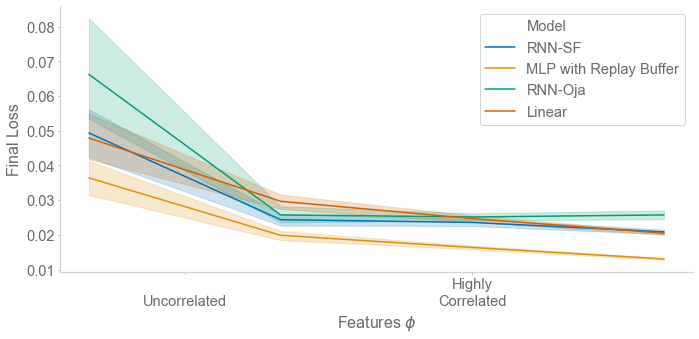

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

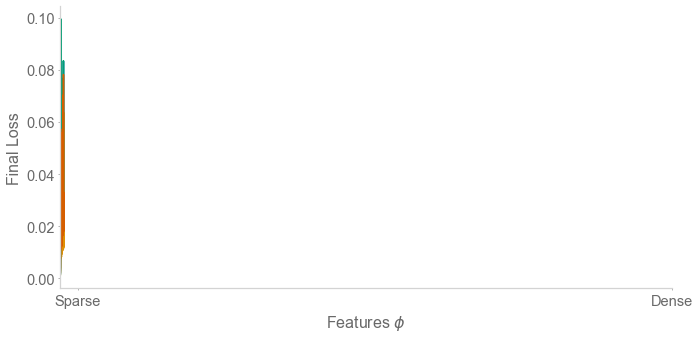

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
plt.xticks([1, np.unique(init_sparsities).size-2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [95]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [77]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [104]:
def get_nan_mask(im, leave_edge_nans=False):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    if not leave_edge_nans:
        return np.isnan(im)
    else:
        mask = np.isnan(im)
        nrows, ncols = im.shape
        for i in range(nrows):
            j = 0
            while np.isnan(im[i,j]) and (j < ncols):
                mask[i,j] = False
                j += 1
        return mask

In [121]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True
    ):
    
    # Collect data into a meshgrid
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    
    # Plot raw grid values
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
            
        
    # Mark NaNs
    nan_mask = np.isnan(z)
    plot_nan_mask = get_nan_mask(z, leave_edge_nans=leave_edge_nans)

    if interpolate:
        if np.sum(plot_nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[plot_nan_mask].flatten(),
                 y[plot_nan_mask].flatten()]).T
                )
            z[plot_nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)
    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap
                     )
    if contours is not None:
        cntrs = plt.contour(
            x, y, z, contours,
            colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

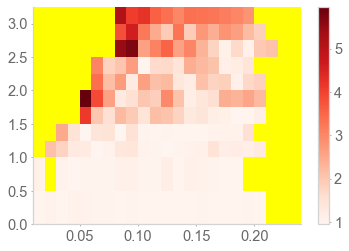

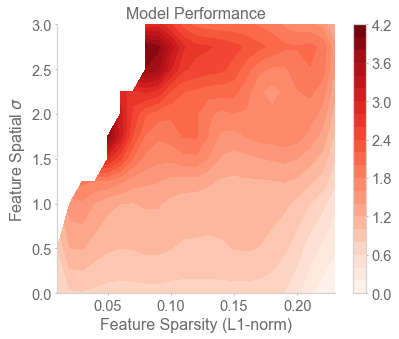

In [117]:
# RNN-SF
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

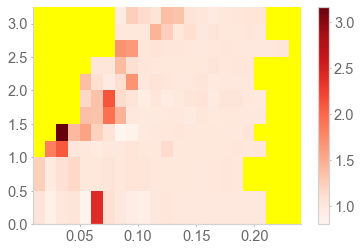

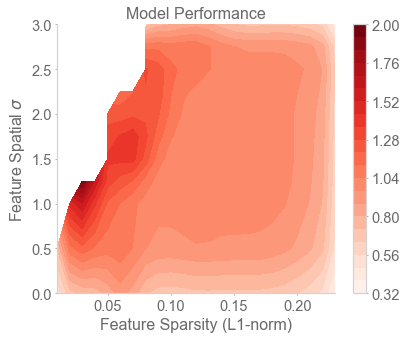

In [122]:
# RNN-Oja
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

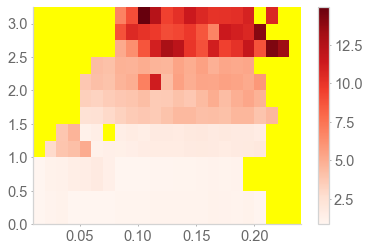

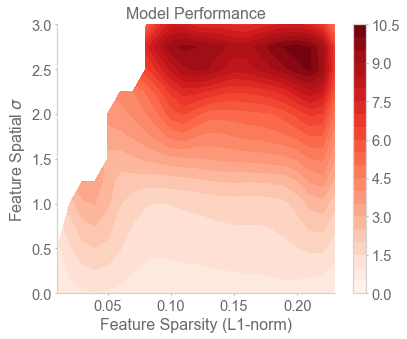

In [123]:
# Linear
_gamma = 0.75
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses
    )

In [82]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-SF Chance')
)]
print(x)
print(np.mean(x))

[]
nan


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-Oja')
)]
print(x)
print(np.mean(x))

[]
nan


In [27]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='RNN-SF')
)]
print(x)
print(np.mean(x))

[]
nan


In [28]:
x = final_losses[np.logical_and(
np.logical_and(
    init_sparsities=='0.012206896551724133',
    sigmas=='2.5'),
np.logical_and(
    gammas==0.75,
    models=='Linear')
)]
print(x)
print(np.mean(x))

[]
nan


# Testing

In [18]:
from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, Hopfield
from run_td_rnn import run as run_rnn

sparsity_p = 0.007103448275862068
spatial_sigma = 1.25
num_states = input_size = 20*20
num_steps = 2000
dataset = sf_inputs_discrete.Sim2DWalk
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma
    }
dataset_config = {
    'num_steps': num_steps, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

net = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, #'lr': -0.02046,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'clamp',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': True
        }
    )
_, _, _, net = run_rnn(
    'test/', net, dataset, dataset_config,
    gamma=0.6,
    train_net=True, test_over_all=False
    )

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=146055, Sat Jan  1 15:18:10 2022)


KeyboardInterrupt: 

In [ ]:
netT = AnalyticSR(
    num_states=input_size, gamma=0.6,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 0.1,
        'output_params':{
            'num_iterations':25, 'nonlinearity': 'sigmoid',
            #'nonlinearity_args': [-0.055744, 2.045]
            }, 'parameterize': False
        }
    )
netT.ca3.sigmoid_a.fill_(0.9758)
netT.ca3.sigmoid_b.fill_(-2.0594)
netT.ca3.parameterize = True

In [ ]:
dataset_config = {
    'num_steps': 6000, 'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
    }

out, loss, dset, _net = run_rnn(
    'test/', netT, dataset, dataset_config,
    gamma=0.6,
    train_net=False, test_over_all=False
    )

In [ ]:
from utils import get_firing_field
from scipy import ndimage
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(out.shape[1])
np.random.shuffle(neurs)
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, out[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.show()